# **1**

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = sns.load_dataset('titanic')

print(f"Rozmiar zbioru: {df.shape}")
df.head()

Rozmiar zbioru: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


# **2.1**

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

--- DESCRIBE ---
         survived      pclass         age  

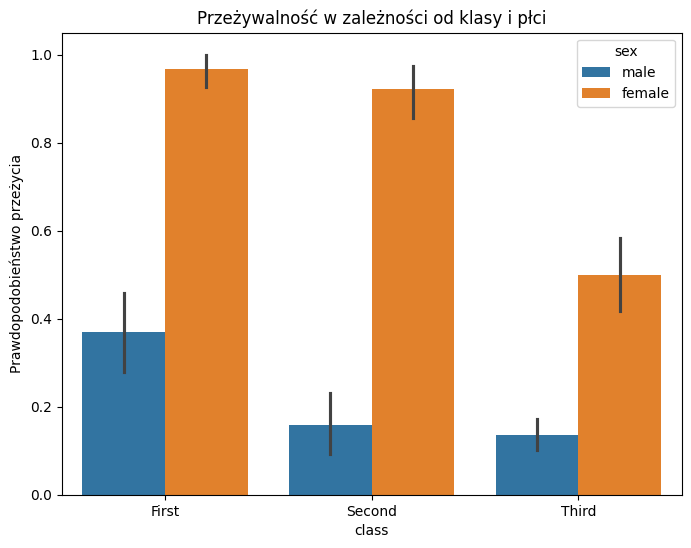

In [ ]:

print("--- INFO ---")
print(df.info())
print("\n--- DESCRIBE ---")
print(df.describe())

print("\n--- BRAKI DANYCH ---")
print(df.isnull().sum())
print(f"Ogólna przeżywalność: {df['survived'].mean():.2%}")

print("\nPrzeżywalność wg płci:")
print(df.groupby('sex')['survived'].mean())

print("\nPrzeżywalność wg klasy:")
print(df.groupby('class', observed=True)['survived'].mean())

plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='class', y='survived', hue='sex')
plt.title('Przeżywalność w zależności od klasy i płci')
plt.ylabel('Prawdopodobieństwo przeżycia')
plt.show()

2.2

In [ ]:
cols_to_drop = ['deck', 'embark_town', 'alive', 'who', 'adult_male']
df_clean = df.drop(columns=cols_to_drop)

df_clean = df_clean.dropna(subset=['embarked'])

df_clean['age'] = df_clean['age'].fillna(df_clean['age'].median())

print(f"Brakujące wartości po czyszczeniu:\n{df_clean.isnull().sum()}")

Brakujące wartości po czyszczeniu:
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
class       0
alone       0
dtype: int64


In [ ]:
df_encoded = pd.get_dummies(df_clean, columns=['sex', 'embarked', 'class'], drop_first=True)

print(df_encoded.head())

   survived  pclass   age  sibsp  parch     fare  alone  sex_male  embarked_Q  \
0         0       3  22.0      1      0   7.2500  False      True       False   
1         1       1  38.0      1      0  71.2833  False     False       False   
2         1       3  26.0      0      0   7.9250   True     False       False   
3         1       1  35.0      1      0  53.1000  False     False       False   
4         0       3  35.0      0      0   8.0500   True      True       False   

   embarked_S  class_Second  class_Third  
0        True         False         True  
1       False         False        False  
2        True         False         True  
3        True         False        False  
4        True         False         True  


In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('survived', axis=1)
y = df_encoded['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (711, 11), Test shape: (178, 11)


In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})

coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

print("3 najważniejsze zmienne:")
print(coef_df.head(3))

coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
print("\nPełna tabela z Odds Ratio:")
print(coef_df[['Feature', 'Coefficient', 'Odds_Ratio']])

sex_coef = coef_df[coef_df['Feature'] == 'sex_male']['Odds_Ratio'].values[0]
print(f"\nInterpretacja dla sex_male: Szansa na przeżycie dla mężczyzny jest {sex_coef:.2f} razy mniejsza/większa niż dla kobiety (przy ustalonych pozostałych zmiennych).")

3 najważniejsze zmienne:
    Feature  Coefficient  Abs_Coefficient
6  sex_male    -2.475732         2.475732
0    pclass    -0.783356         0.783356
5     alone    -0.624589         0.624589

Pełna tabela z Odds Ratio:
         Feature  Coefficient  Odds_Ratio
6       sex_male    -2.475732    0.084101
0         pclass    -0.783356    0.456870
5          alone    -0.624589    0.535481
2          sibsp    -0.399232    0.670835
7     embarked_Q     0.390690    1.478000
10   class_Third    -0.369191    0.691293
8     embarked_S    -0.284930    0.752067
3          parch    -0.216880    0.805027
9   class_Second    -0.043804    0.957142
1            age    -0.034634    0.965959
4           fare     0.002344    1.002346

Interpretacja dla sex_male: Szansa na przeżycie dla mężczyzny jest 0.08 razy mniejsza/większa niż dla kobiety (przy ustalonych pozostałych zmiennych).


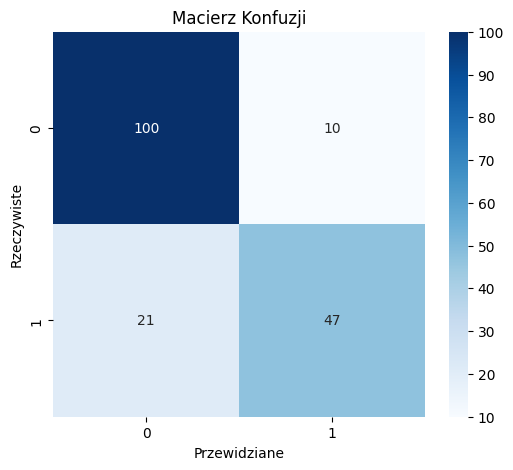

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Macierz Konfuzji')
plt.ylabel('Rzeczywiste')
plt.xlabel('Przewidziane')
plt.show()

In [ ]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)

print(f"Accuracy:    {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision:   {precision_score(y_test, y_pred):.4f}")
print(f"Recall:      {recall_score(y_test, y_pred):.4f}")
print(f"F1-score:    {f1_score(y_test, y_pred):.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy:    0.8258
Precision:   0.8246
Recall:      0.6912
F1-score:    0.7520
Specificity: 0.9091


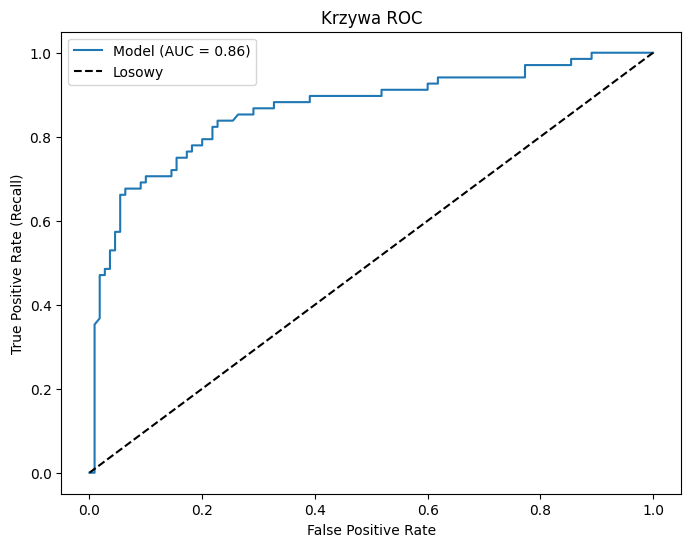

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Model (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Losowy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Krzywa ROC')
plt.legend()
plt.show()

In [ ]:
print("""
Odpowiedź:
W przypadku katastrofy takiej jak Titanic, najważniejszą metryką jest prawdopodobnie Recall (Czułość).
Dlaczego? Jeśli celem modelu byłoby np. zidentyfikowanie osób potrzebujących ratunku priorytetowo,
chcemy wykryć jak najwięcej osób, które rzeczywiście przeżyły (lub miały szansę przeżyć),
nawet kosztem kilku fałszywych alarmów (Precision).
W kontekście historycznym, chcemy poprawnie zidentyfikować ocalałych.
""")


Odpowiedź:
W przypadku katastrofy takiej jak Titanic, najważniejszą metryką jest prawdopodobnie Recall (Czułość).
Dlaczego? Jeśli celem modelu byłoby np. zidentyfikowanie osób potrzebujących ratunku priorytetowo,
chcemy wykryć jak najwięcej osób, które rzeczywiście przeżyły (lub miały szansę przeżyć),
nawet kosztem kilku fałszywych alarmów (Precision).
W kontekście historycznym, chcemy poprawnie zidentyfikować ocalałych.



In [ ]:

thresholds_list = [0.3, 0.4, 0.5, 0.6, 0.7]

print(f"{'Próg':<10} {'Precision':<10} {'Recall':<10}")
print("-" * 30)

for t in thresholds_list:
    y_pred_t = (y_prob >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    print(f"{t:<10} {prec:.4f}     {rec:.4f}")

Próg       Precision  Recall    
------------------------------
0.3        0.6706     0.8382
0.4        0.7324     0.7647
0.5        0.8246     0.6912
0.6        0.8776     0.6324
0.7        0.8780     0.5294


In [ ]:
model_balanced = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
model_balanced.fit(X_train, y_train)
y_pred_bal = model_balanced.predict(X_test)

print("Model Bazowy - Recall:", recall_score(y_test, y_pred))
print("Model Balanced - Recall:", recall_score(y_test, y_pred_bal))

Model Bazowy - Recall: 0.6911764705882353
Model Balanced - Recall: 0.7794117647058824


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

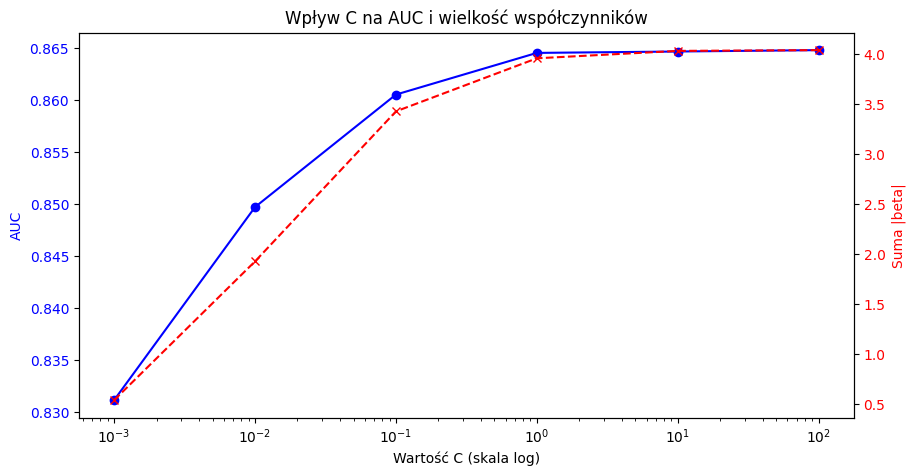

In [ ]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
auc_scores = []
coef_sums = []

for c in C_values:
    m = LogisticRegression(C=c, penalty='l2', max_iter=1000, random_state=42)
    m.fit(X_train_scaled, y_train)

    p = m.predict_proba(X_test_scaled)[:, 1]
    auc = roc_auc_score(y_test, p)
    auc_scores.append(auc)

    s = np.sum(np.abs(m.coef_))
    coef_sums.append(s)

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Wartość C (skala log)')
ax1.set_ylabel('AUC', color='blue')
ax1.semilogx(C_values, auc_scores, color='blue', marker='o')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Suma |beta|', color='red')
ax2.semilogx(C_values, coef_sums, color='red', marker='x', linestyle='--')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Wpływ C na AUC i wielkość współczynników')
plt.show()

In [ ]:

c_val = 0.1

# L2 (Ridge)
model_l2 = LogisticRegression(C=c_val, penalty='l2', solver='lbfgs', max_iter=1000)
model_l2.fit(X_train_scaled, y_train)

model_l1 = LogisticRegression(C=c_val, penalty='l1', solver='liblinear', max_iter=1000)
model_l1.fit(X_train_scaled, y_train)

print(f"Liczba cech: {X_train.shape[1]}")
print(f"L2 (Ridge) - współczynniki zerowe: {np.sum(model_l2.coef_ == 0)}")
print(f"L1 (Lasso) - współczynniki zerowe: {np.sum(model_l1.coef_ == 0)}")

l1_coefs = pd.Series(model_l1.coef_[0], index=X.columns)
print("\nWspółczynniki modelu L1 (Lasso):")
print(l1_coefs[l1_coefs != 0])

Liczba cech: 11
L2 (Ridge) - współczynniki zerowe: 0
L1 (Lasso) - współczynniki zerowe: 1

Współczynniki modelu L1 (Lasso):
pclass        -0.651908
age           -0.277042
sibsp         -0.115968
parch         -0.004478
fare           0.029544
alone         -0.006674
sex_male      -1.127400
embarked_Q     0.004188
embarked_S    -0.131105
class_Third   -0.063629
dtype: float64
